In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import pandas as pd
from termcolor import colored
import numpy as np
from collections import OrderedDict
from collections import Counter
import matplotlib.pyplot as plt
from natsort import natsorted
import sys
import pickle
import seaborn as sns

# Display pandas df without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x))



In [3]:
num_robot = 24
fieldsPerKilobot = 7
experiment_time = 2000
num_run = 12

num_areas = 16
fieldsPerArea = 6 #id, posx, posy, color, completed?, #kilo_in_area

In [4]:
bin_edges = np.linspace(0, 24, 13)
bin_edges

array([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24])

In [5]:
results_folders = '/home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_realEXP/'

In [6]:
# results_folders

In [7]:
if not os.path.isdir(results_folders):
    print(colored("Error, " + results_folders + " does not exist", 'red'))
else:
    print(colored("OK, " + results_folders + " exists", 'green'))

OK, /home/luigi/Documents/ARGoS/argos_results_scripts/DHTF/standAlone/results_realEXP/ exists


In [8]:
def distances(xy1, xy2):
    d0 = np.subtract.outer(xy1[:,0], xy2[:,0])
    d1 = np.subtract.outer(xy1[:,1], xy2[:,1])
    return np.hypot(d0, d1)

In [9]:
def get_histogram(distribution_history, bins):
    hist_val = np.array([])
    for x in distribution_history.T:
    #     print(x.size)
        hist,_= np.histogram(x,bins)
        hist_val = np.vstack([hist_val, hist]) if hist_val.size else hist

    print(hist_val.shape)
    return hist_val

def plot_heatmap(histogram,bins,imgName):
    fig = plt.figure(figsize=(20, 5), dpi=160)

    y_values = histogram.T
    y_edges = bins.round(decimals=2)

    # plt.xlabel('time(s)')
    yticks = y_edges


    # print("\t v_max:", v_max)
    ax = sns.heatmap(y_values, yticklabels=yticks, cmap="viridis", vmin=0, vmax=40)
    ax.set_title("Position distribution around red areas")
    ax.set_xlabel('time(s)')
    plt.ylabel('#robots')
    plt.yticks(np.arange(y_edges.size), yticks)
    fileName = "REAL_adaptiveTimeout_positionDistribution_"+imgName+".png"
    print(fileName)
    
    plt.savefig(fileName)
    plt.show()

In [10]:
# timeout_folder = "Mixed_AdaptiveWalk_2021-07-13_robots#24_timeout#1_respawn#30_NumAreas#16_redAreas#8_1800#seconds"
# kiloFilename = "seed#1_kiloLOG.tsv"
# areaFilename = "seed#1_areaLOG.tsv"

### KiloLog labels

In [11]:
kiloLOG_label = ['time']
for i in range(0, num_robot*fieldsPerKilobot, fieldsPerKilobot):
    kiloLOG_label += ['id' + str(i // fieldsPerKilobot), 'col' + str(i // fieldsPerKilobot), 'posx' + str(i // fieldsPerKilobot), 'posy' + str(i // fieldsPerKilobot), 'ori' + str(i // fieldsPerKilobot), 'state' + str(i // fieldsPerKilobot), 'timer' + str(i // fieldsPerKilobot)]

In [12]:
# print(kiloLOG_label)

#### Kilobot Position Labels

In [13]:
kiloPOS_label = []
for i in range(num_robot):
    kiloPOS_label += ["posx"+str(i),"posy"+str(i)]

In [14]:
# print(kiloPOS_label)

### Area labels

In [15]:
df_area_labels = ['time']
for i in range(0, num_areas*fieldsPerArea, fieldsPerArea):
    # print(i, end=", ")
    df_area_labels += ['id' + str(i // fieldsPerArea), 'posx' + str(i // fieldsPerArea), 'posy' + str(i // fieldsPerArea), 'color' + str(i // fieldsPerArea),
                        'completed' + str(i // fieldsPerArea), 'contained' + str(i // fieldsPerArea)]

In [16]:
# print(df_area_labels)

#### Area Position Labels

In [17]:
areaPOS_label = []
for i in range(num_areas):
    areaPOS_label += ["posx"+str(i),"posy"+str(i)]

areaCOL_label = []
for i in range(num_areas):
    areaCOL_label += ["color"+str(i)]

In [18]:
# print(areaPOS_label, end="\n\n")
# print(areaCOL_label)

Timeout folder: Mixed_Adaptive
	Exp configuration: Mixed_Adaptive
timeout_run_count.shape  (12, 1000)
(1000, 12)
REAL_adaptiveTimeout_positionDistribution_Mixed_Adaptive.png


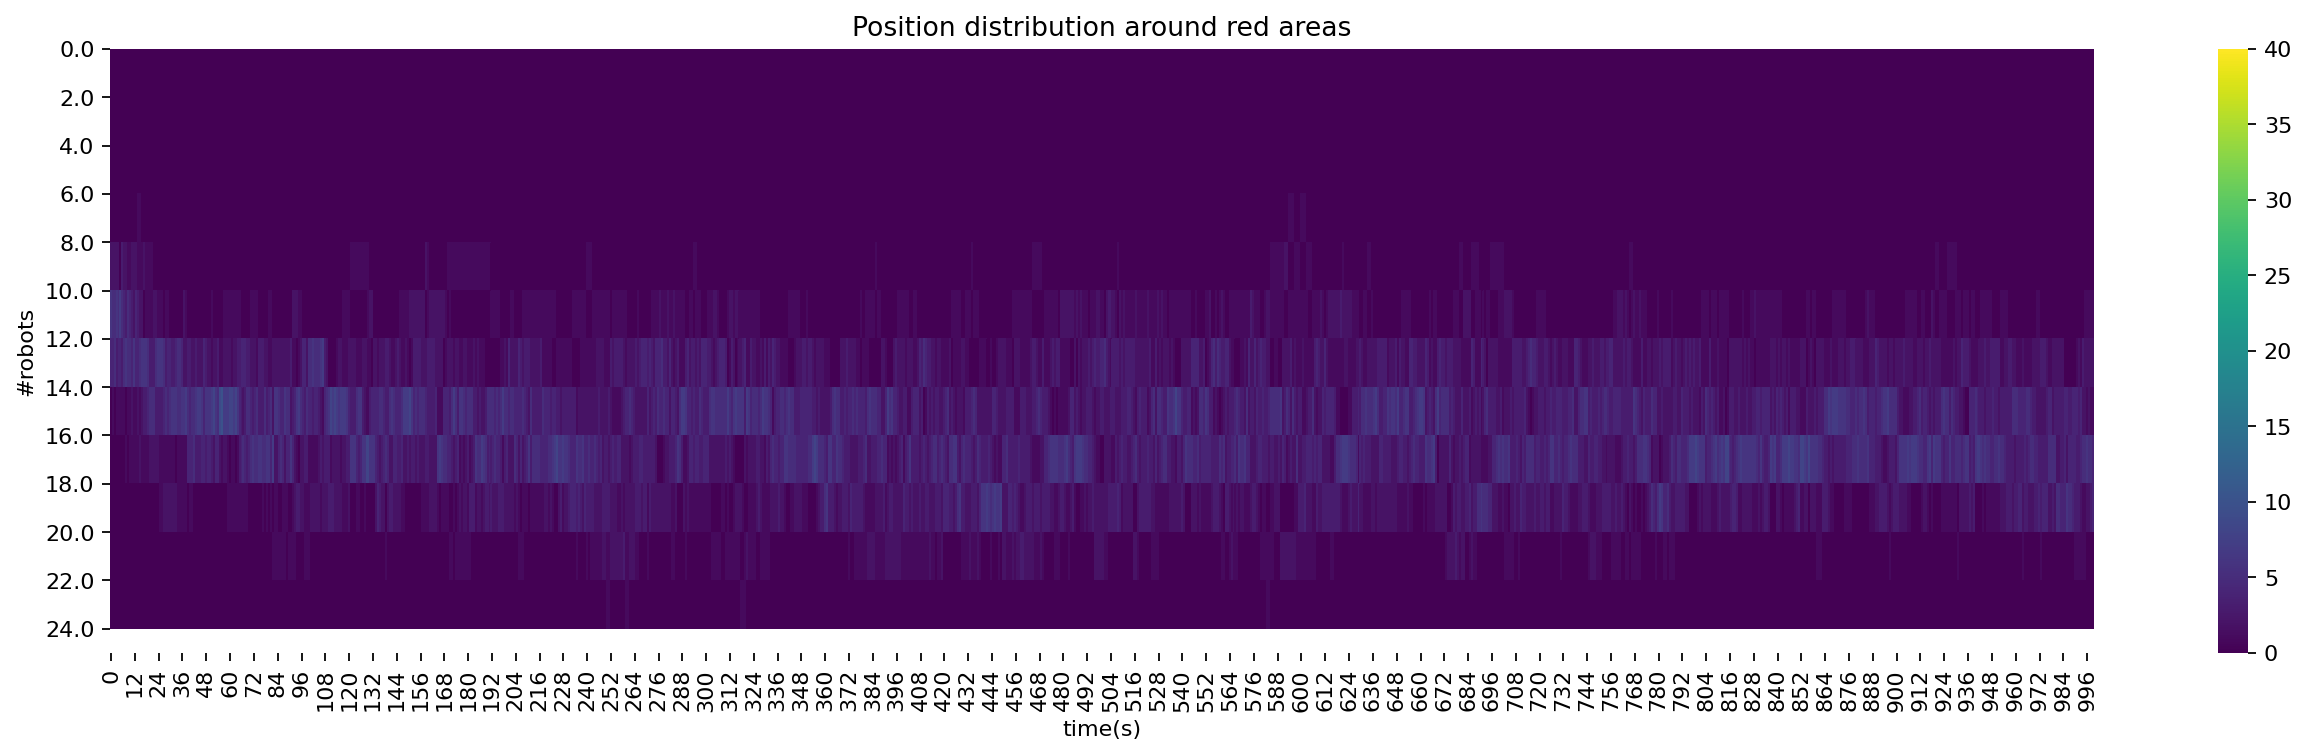

Timeout folder: Regions_Adaptive
	Exp configuration: Regions_Adaptive
timeout_run_count.shape  (12, 1000)
(1000, 12)
REAL_adaptiveTimeout_positionDistribution_Regions_Adaptive.png


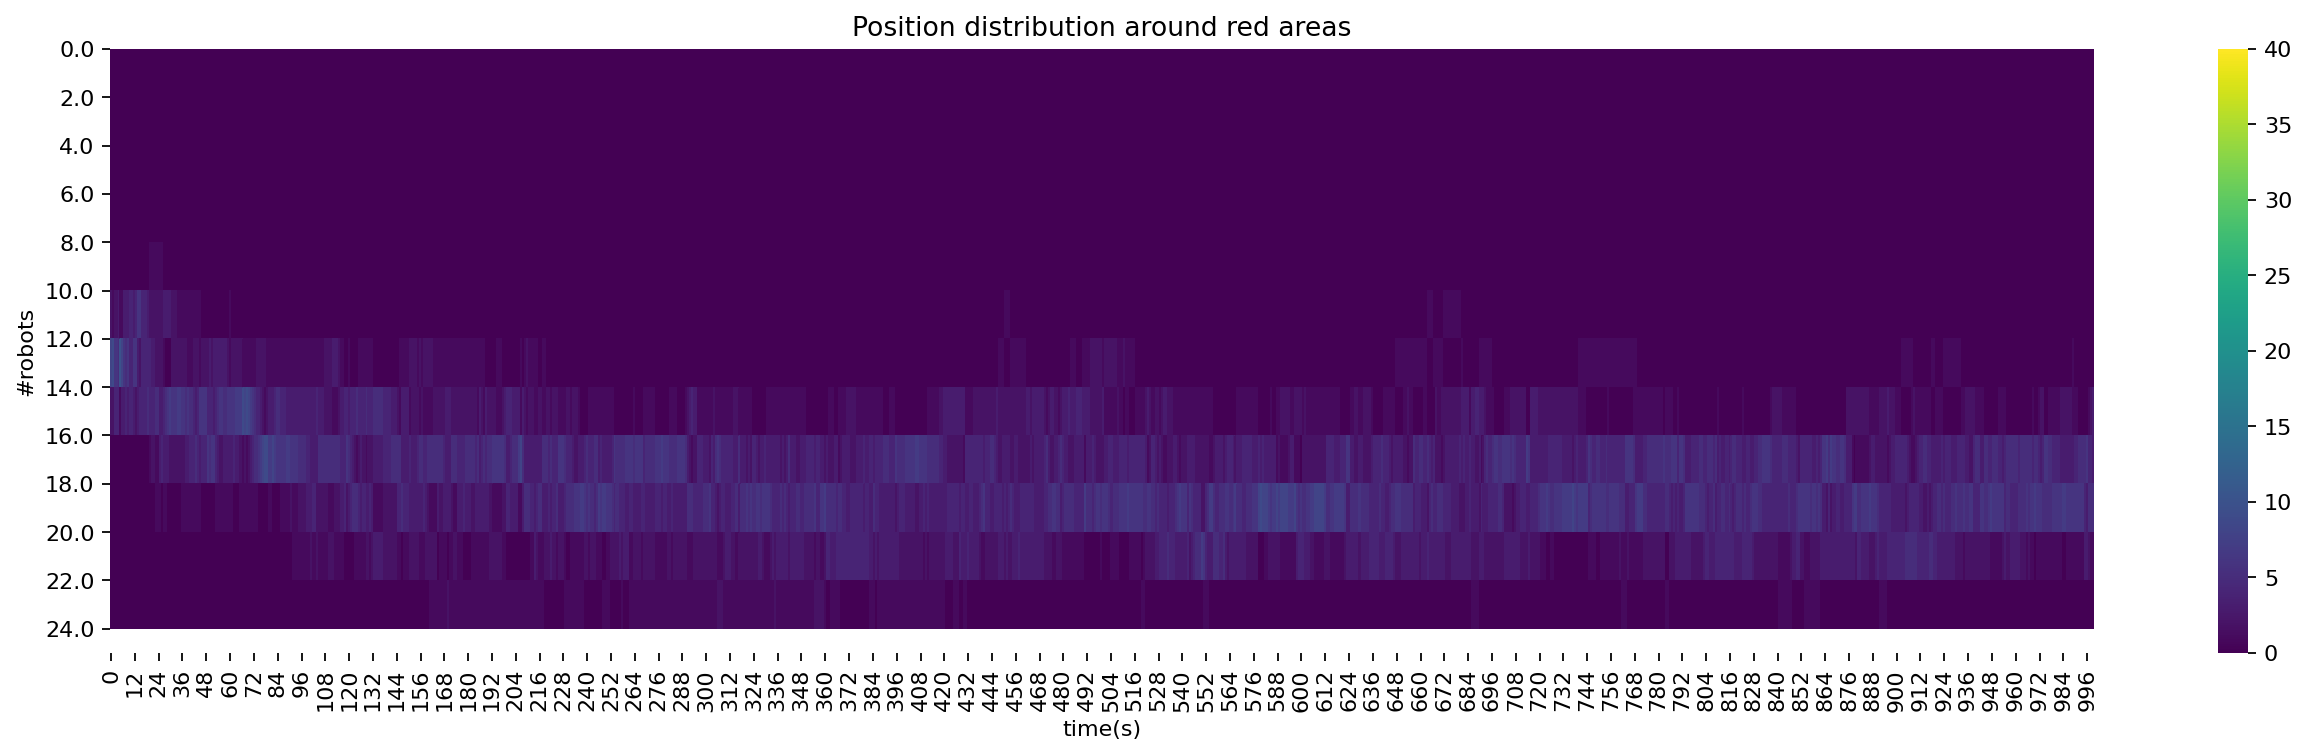

In [19]:
for results_folder in os.listdir(results_folders):
    for timeout_folder in natsorted(os.listdir(os.path.join(results_folders,results_folder))):
        timeout = -1
        print(colored("Timeout folder:", 'blue'),timeout_folder)

        parameters = timeout_folder.split("_")


        exp_config = parameters[0]+"_"+parameters[1]
        print("\tExp configuration:",exp_config)
        

        timeout_run_count = np.array([])
        evaluate_seed = False
        for filename in natsorted(os.listdir(os.path.join(results_folders, results_folder, timeout_folder))):
            
#             print('\tfilename: ', filename)
            
            if filename.endswith("areapos.txt"):
                if not os.path.getsize(os.path.join(results_folders, results_folder, timeout_folder, filename)) > 0:
                    print(colored("\tWARNING, empty file at:" + filename, 'red'))
                    continue
                df_areaLOG = pd.read_csv(os.path.join(results_folders, results_folder, timeout_folder, filename), sep="\t", header=None)

            if filename.endswith("kilopos.txt"):
                if not os.path.getsize(os.path.join(results_folders, results_folder, timeout_folder, filename)) > 0:
                    print(colored("\tWARNING, empty file at:" + filename, 'red'))
                    continue
    #             print('\tfilename: ', filename)
                df_kiloPOS = pd.read_csv(os.path.join(results_folders, results_folder, timeout_folder, filename), sep="\t", header=None)

                evaluate_seed = True

            if evaluate_seed:
    #             print("\tProcessing")



                df_areaLOG.columns = df_area_labels
                color_val = df_areaLOG[areaCOL_label].iloc[:1,:].values.reshape(-1)
                area_pos = df_areaLOG[areaPOS_label].iloc[0, :].values.reshape(-1, 2)

                df_kiloPOS.columns = kiloLOG_label

                single_run_count = np.array([])
                for row in df_kiloPOS[kiloPOS_label].values:
                #     print(row)
                    kilo_pos_t = row.reshape(-1,2)
                    in_area = np.argmin(distances(kilo_pos_t, area_pos),axis=1)
                #    color_val[in_area]
                #    np.count_nonzero(color_val[in_area])

                #     print("kilo_pos_t.shape: ",kilo_pos_t.shape)
                #     print("in_area.shape:",in_area.shape)
                #     print(np.count_nonzero(color_val[in_area]), end=", ")
                    single_run_count = np.append(single_run_count,np.count_nonzero(color_val[in_area]))
                #     print(end="\n\n")

                timeout_run_count = np.vstack((timeout_run_count, single_run_count)) if timeout_run_count.size else single_run_count
    #             print("timeout_run_count.shape ",timeout_run_count.shape)

                evaluate_seed = False

        print("timeout_run_count.shape ",timeout_run_count.shape)        
        histogram = get_histogram(timeout_run_count, bin_edges)
        plot_heatmap(histogram, bin_edges,exp_config)

In [20]:
# timeout_run_count.shape

In [21]:

# hist_val = np.array([])
# for x in timeout_run_count.T:
# #     print(x.size)
#     hist,_= np.histogram(x,bin_edges)
#     hist_val = np.vstack([hist_val, hist]) if hist_val.size else hist

# print(hist_val.shape)
   
    
    
# fig = plt.figure(figsize=(20, 5), dpi=160)

# y_values = hist_val.T
# y_edges = bin_edges.round(decimals=2)

# # plt.xlabel('time(s)')
# yticks = y_edges


# # print("\t v_max:", v_max)
# ax = sns.heatmap(y_values, yticklabels=yticks, cmap="viridis", vmin=0)
# ax.set_title("Position distribution around red areas")
# ax.set_xlabel('time(s)')
# plt.ylabel('#robots')
# plt.yticks(np.arange(y_edges.size), yticks)
# # plt.savefig("position_distribution_X_timeout"+str(timeout)+".png")
# plt.show()